<IPython.core.display.Javascript object>


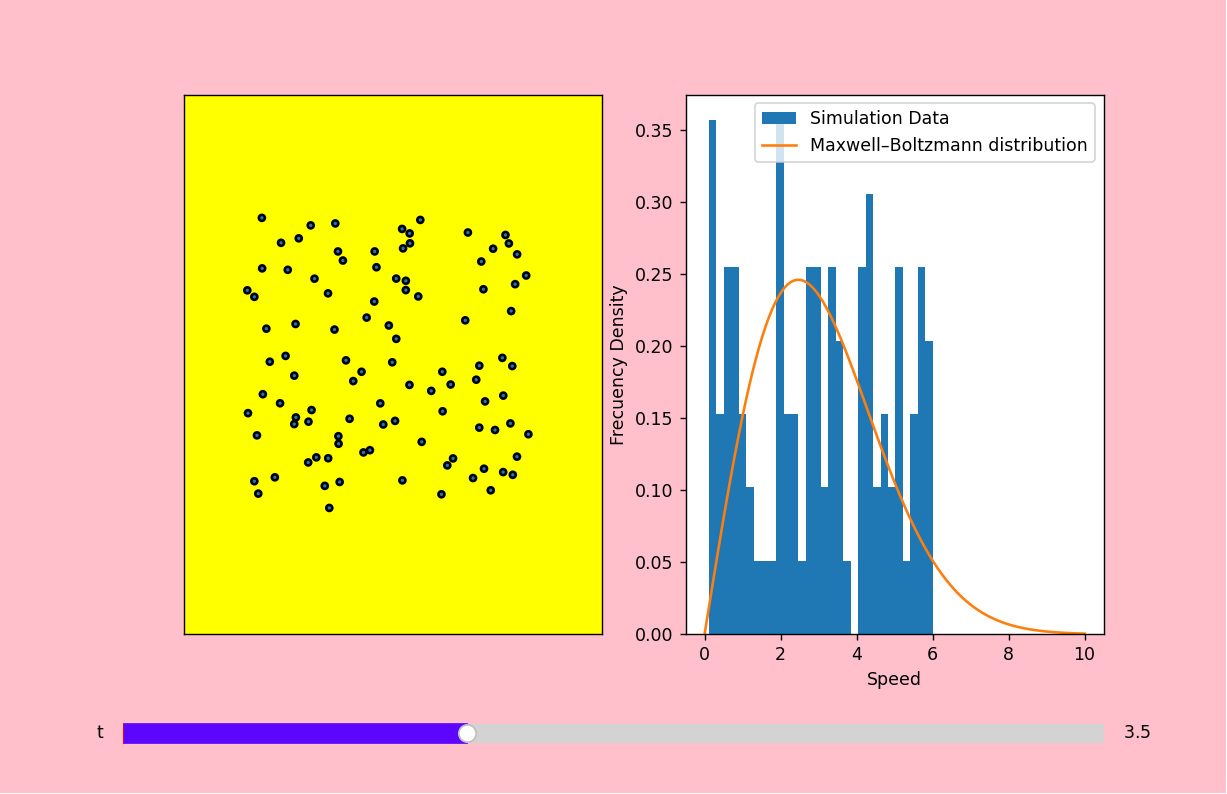

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import time
from matplotlib.widgets import Slider
# %matplotlib notebook


class Particle:
    """Define physics of elastic collision."""
    
    def __init__(self, mass, radius, position, velocity):
        # Initialize a Particle object
        
        # mass : the mass of particle
        # radius : the radius of particle
        # position : the position vector of the particle to be created : position=[x,y]
        # velocity : the velocity vector of the particle to be created : velocity=[vx,vy]
        
        self.mass = mass
        self.radius = radius
        
        
        self.position = np.array(position)    
        self.velocity = np.array(velocity)
        
        
        self.solpos = [np.copy(self.position)]   #  position and velocity recorded during the simulation
        self.solvel = [np.copy(self.velocity)]
        self.solvel_mag = [np.linalg.norm(np.copy(self.velocity))]

        
    def compute_step(self, step):
        """Compute position of next step."""
       
        self.position += step * self.velocity     
        self.solpos.append(np.copy(self.position)) 
        self.solvel.append(np.copy(self.velocity)) 
        self.solvel_mag.append(np.linalg.norm(np.copy(self.velocity))) 
        
    
    def check_coll(self, particle):
        """Check if there is a collision with another particle."""
        
        r1, r2 = self.radius, particle.radius   
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < 0:
            return True
        else:
            return False

    
    def compute_coll(self, particle, step):
        """Compute velocity after collision with another particle."""
        
        m1, m2 = self.mass, particle.mass     
        r1, r2 = self.radius, particle.radius
        v1, v2 = self.velocity, particle.velocity
        x1, x2 = self.position, particle.position
        di = x2-x1
        norm = np.linalg.norm(di)
        if norm-(r1+r2)*1.1 < step*abs(np.dot(v1-v2, di))/norm:
            self.velocity = v1 - 2. * m2/(m1+m2) * np.dot(v1-v2, di) / (np.linalg.norm(di)**2.) * di
            particle.velocity = v2 - 2. * m1/(m2+m1) * np.dot(v2-v1, (-di)) / (np.linalg.norm(di)**2.) * (-di)
            

    def compute_refl(self, step, size):
        """Compute velocity after hitting an edge.
        """
        # step: the computation step
        # size the medium size
        r, v, x = self.radius, self.velocity, self.position
        projx = step*abs(np.dot(v,np.array([1.,0.])))
        projy = step*abs(np.dot(v,np.array([0.,1.])))
        if abs(x[0])-r < projx or abs(size-x[0])-r < projx:
            self.velocity[0] *= -1
        if abs(x[1])-r < projy or abs(size-x[1])-r < projy:
            self.velocity[1] *= -1.


def solve_step(particle_list, step, size):
    """Solve a step for every particle."""
    
    for i in range(len(particle_list)):                   # Detect edge-hitting and collision of every particle
        particle_list[i].compute_refl(step,size)
        for j in range(i+1,len(particle_list)):
                particle_list[i].compute_coll(particle_list[j],step)    

    for particle in particle_list:                        # Compute position of every particle  
        particle.compute_step(step)


def init_list_random(N, radius, mass, boxsize):
    """ to Generate N Particle objects in a random way in a list."""
    particle_list = []

    for i in range(N):
        
        v_mag = np.random.rand(1)*6
        v_ang = np.random.rand(1)*2*np.pi
        v = np.append(v_mag*np.cos(v_ang), v_mag*np.sin(v_ang))
        
        collision = True
        while(collision == True):
            
            collision = False
            pos = radius + np.random.rand(2)*(boxsize-2*radius) 
            newparticle = Particle(mass, radius, pos, v)
            for j in range(len(particle_list)):

                collision = newparticle.check_coll( particle_list[j] )

                if collision == True:
                    break

        particle_list.append(newparticle)
    return particle_list



particle_number = 100
boxsize = 200.


tfin = 10                  
stepnumber = 150

timestep = tfin/stepnumber

particle_list = init_list_random(particle_number, radius = 2, mass = 1, boxsize = 200)

    
df_hund = pd.DataFrame()
df_hund['Particles']= particle_list

# Compute simulation (It takes some time if stepnumber and particle_number are large)
for i in range(stepnumber):
    solve_step(particle_list, timestep, boxsize)


####################visualization using matplotlib.It use a slider to change the time########################

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6),facecolor='pink')
ax = fig.add_subplot(1,2,1)
ax.set_facecolor("yellow")

hist = fig.add_subplot(1,2,2)

plt.subplots_adjust(bottom=0.2,left=0.15)

ax.axis('equal')
ax.axis([-1, 30, -1, 30])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])


# Draw Particles as circles
circle = [None]*particle_number                   
for i in range(particle_number):
    circle[i] = plt.Circle((df_hund.Particles.iloc[i].solpos[0][0], df_hund.Particles.iloc[i].solpos[0][1]), df_hund.Particles.iloc[i].radius, ec="black", lw=1.5, zorder=20)
    ax.add_patch(circle[i])

# Graph Particles speed histogram
vel_mod = [df_hund.Particles.iloc[i].solvel_mag[0] for i in range(len(particle_list))]
df_hund['modulus_velocity'] = vel_mod
hist.hist(df_hund.modulus_velocity, bins= 30, density = True, label = "Simulation Data")
hist.set_xlabel("Speed")
hist.set_ylabel("Frecuency Density")

#  Boltzmann distribution

def total_Energy(particle_list, index):        
    """total energy should be constant for any time index"""

    return sum([particle_list[i].mass / 2. * particle_list[i].solvel_mag[index]**2  for i in range(len(particle_list))])


E = total_Energy(particle_list, 0) #constant
Average_E = E/len(particle_list) #constant
k = 1.38064852e-23  #constant
T = 2*Average_E/(2*k)  #constant
m = df_hund.Particles.iloc[0].mass
v = np.linspace(0,10,120)

df = pd.DataFrame()
df['speed'] = v
fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
df['f_speed'] = fv

hist.plot(df.speed,df.f_speed, label = "Maxwell–Boltzmann distribution") 
hist.legend(loc ="upper right")



slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])

slider = Slider(slider_ax,      # the axes object containing the slider
                  't',            #  slider parameter
                  0,          # minimal value of t
                  tfin,          # maximal value of t
                  valinit=0,  # initial value of t
                  color = '#5c06ff' 
                 )

def update(time):
    i = int(np.rint(time/timestep))

    # drawing particles as circle
    for j in range(particle_number):
        circle[j].center = df_hund.Particles.iloc[j].solpos[i][0], df_hund.Particles.iloc[j].solpos[i][1]

    hist.clear()   

    # Graph Particles speed histogram 

    vel_mod = [df_hund.Particles.iloc[j].solvel_mag[i] for j in range(len(particle_list))] 
    df_hund['modulus_velocity'] = vel_mod   
    hist.hist(df_hund.modulus_velocity, bins= 30, density = True, label = "Simulation Data")
    hist.set_xlabel("Speed")
    hist.set_ylabel("Frecuency Density")
    
    E = total_Energy(particle_list, i)                      # Computing 2d Boltzmann distribution
    Average_E = E/len(particle_list) 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    m = particle_list[0].mass
    v = np.linspace(0,10,120)

    df = pd.DataFrame()
    df['speed'] = v
    fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
    df['f_speed'] = fv
    hist.plot(df.speed,df.f_speed, label = "Maxwell–Boltzmann distribution") 
    hist.legend(loc ="upper right")
    

slider.on_changed(update)
plt.show()